In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import math
import seaborn as sns

from functools import reduce

from scipy.stats import pearsonr

from sklearn.linear_model import LinearRegression
from sklearn import tree, linear_model
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import explained_variance_score

from mpl_toolkits.basemap import Basemap

In [2]:
# Need to be able to see all columns
pd.set_option('display.max_columns', 999)

Additional data sets that could be useful include the location of police and fire stations as well and the locations of parks and community centers. We believe the locations of these facilities could inherently deter criminals due to the risk of being caught.  

In [3]:
police = pd.read_csv("./data/police_sta.csv").add_prefix("police_")
fire = pd.read_csv("./data/fire_dept.csv").add_prefix("fire_")
community = pd.read_csv("./data/community_centers.csv").add_prefix("community_")
parks = pd.read_csv("./data/parks.csv").add_prefix("parks_")
crime = pd.read_csv("./data/crime.csv", low_memory=False).add_prefix("crime_")

crime.name = "crime"
police.name = "police"
fire.name = "fire"
community.name = "community"
parks.name = "parks"

In [4]:
humidity = pd.read_csv("./data/weather/humidity.csv")
temp = pd.read_csv("./data/weather/temperature.csv")
pressure = pd.read_csv("./data/weather/pressure.csv")
weather_descript = pd.read_csv("./data/weather/weather_description.csv")
wind_dir = pd.read_csv("./data/weather/wind_direction.csv")
wind_speed = pd.read_csv("./data/weather/wind_speed.csv")

humidity.name = "humidity"
temp.name = "temperature"
pressure.name = "pressure"
weather_descript.name = "weather_description"
wind_dir.name = "wind_direction"
wind_speed.name = "wind_speed"

In [5]:
datasets = [crime, police, fire, community, parks, humidity, temp, pressure, weather_descript, wind_dir, wind_speed]

In [6]:
for df in datasets:
    # Some of the datasets have Lat/Long as Y/X, which can be confusing
    # They also have longcoord and latcoord, but they're unsigned, so dropping them
    # Regex is to avoid partial matching
    df.columns = df.columns.str.replace("^[X]", "long", regex=True)
    df.columns = df.columns.str.replace("^[Y]", "lat", regex=True)
    df.drop(list(df.filter(regex="coord")), axis = 1, inplace=True)
    
    # Makes typing easier
    df.columns = [x.lower() for x in df.columns]

In [7]:
### crime ###
# UCR_PART is Uniform Crime Reporting, and attempts to lump crimes into categories
# This is separate from Boston PD's own categorization
# Can't do anything without Lat/Long, so we'll have to drop those
crime.dropna(subset=["crime_lat", "crime_long"], inplace=True)

# Renaming for consistency
crime = crime.rename({"crime_occurred_on_date":"datetime"}, axis=1)

In [8]:
# Anything > -70 is far enough outside our bounds that there's no way it applies to Boston.
# In this case, they're all -1.0/-1.0 AKA useless, so dropping them.
crime.describe()

crime_offense_code     crime_year    crime_month     crime_hour  \
count       399617.000000  399617.000000  399617.000000  399617.000000   
mean          2306.203475    2017.087141       6.648303      13.121571   
std           1179.375999       1.288410       3.283758       6.286262   
min            111.000000    2015.000000       1.000000       0.000000   
25%           1001.000000    2016.000000       4.000000       9.000000   
50%           2907.000000    2017.000000       7.000000      14.000000   
75%           3201.000000    2018.000000       9.000000      18.000000   
max           3831.000000    2019.000000      12.000000      23.000000   

           crime_lat     crime_long  
count  399617.000000  399617.000000  
mean       42.221520     -70.920248  
std         2.085491       3.373472  
min        -1.000000     -71.178674  
25%        42.297105     -71.097223  
50%        42.325538     -71.077619  
75%        42.348546     -71.062583  
max        42.395042      -1.000000

In [9]:
crime = crime[crime.crime_long <= -70]
crime.describe()

crime_offense_code    crime_year    crime_month     crime_hour  \
count       398689.000000  398689.00000  398689.000000  398689.000000   
mean          2305.981981    2017.08691       6.647362      13.123537   
std           1179.555917       1.28886       3.284179       6.285511   
min            111.000000    2015.00000       1.000000       0.000000   
25%           1001.000000    2016.00000       4.000000       9.000000   
50%           2907.000000    2017.00000       7.000000      14.000000   
75%           3201.000000    2018.00000       9.000000      18.000000   
max           3831.000000    2019.00000      12.000000      23.000000   

           crime_lat     crime_long  
count  398689.000000  398689.000000  
mean       42.322124     -71.082997  
std         0.031929       0.029708  
min        42.232413     -71.178674  
25%        42.297424     -71.097374  
50%        42.325600     -71.077667  
75%        42.348577     -71.062609  
max        42.395042     -70.963676

Let's take a look at the types of crimes reported and how they are categorized.

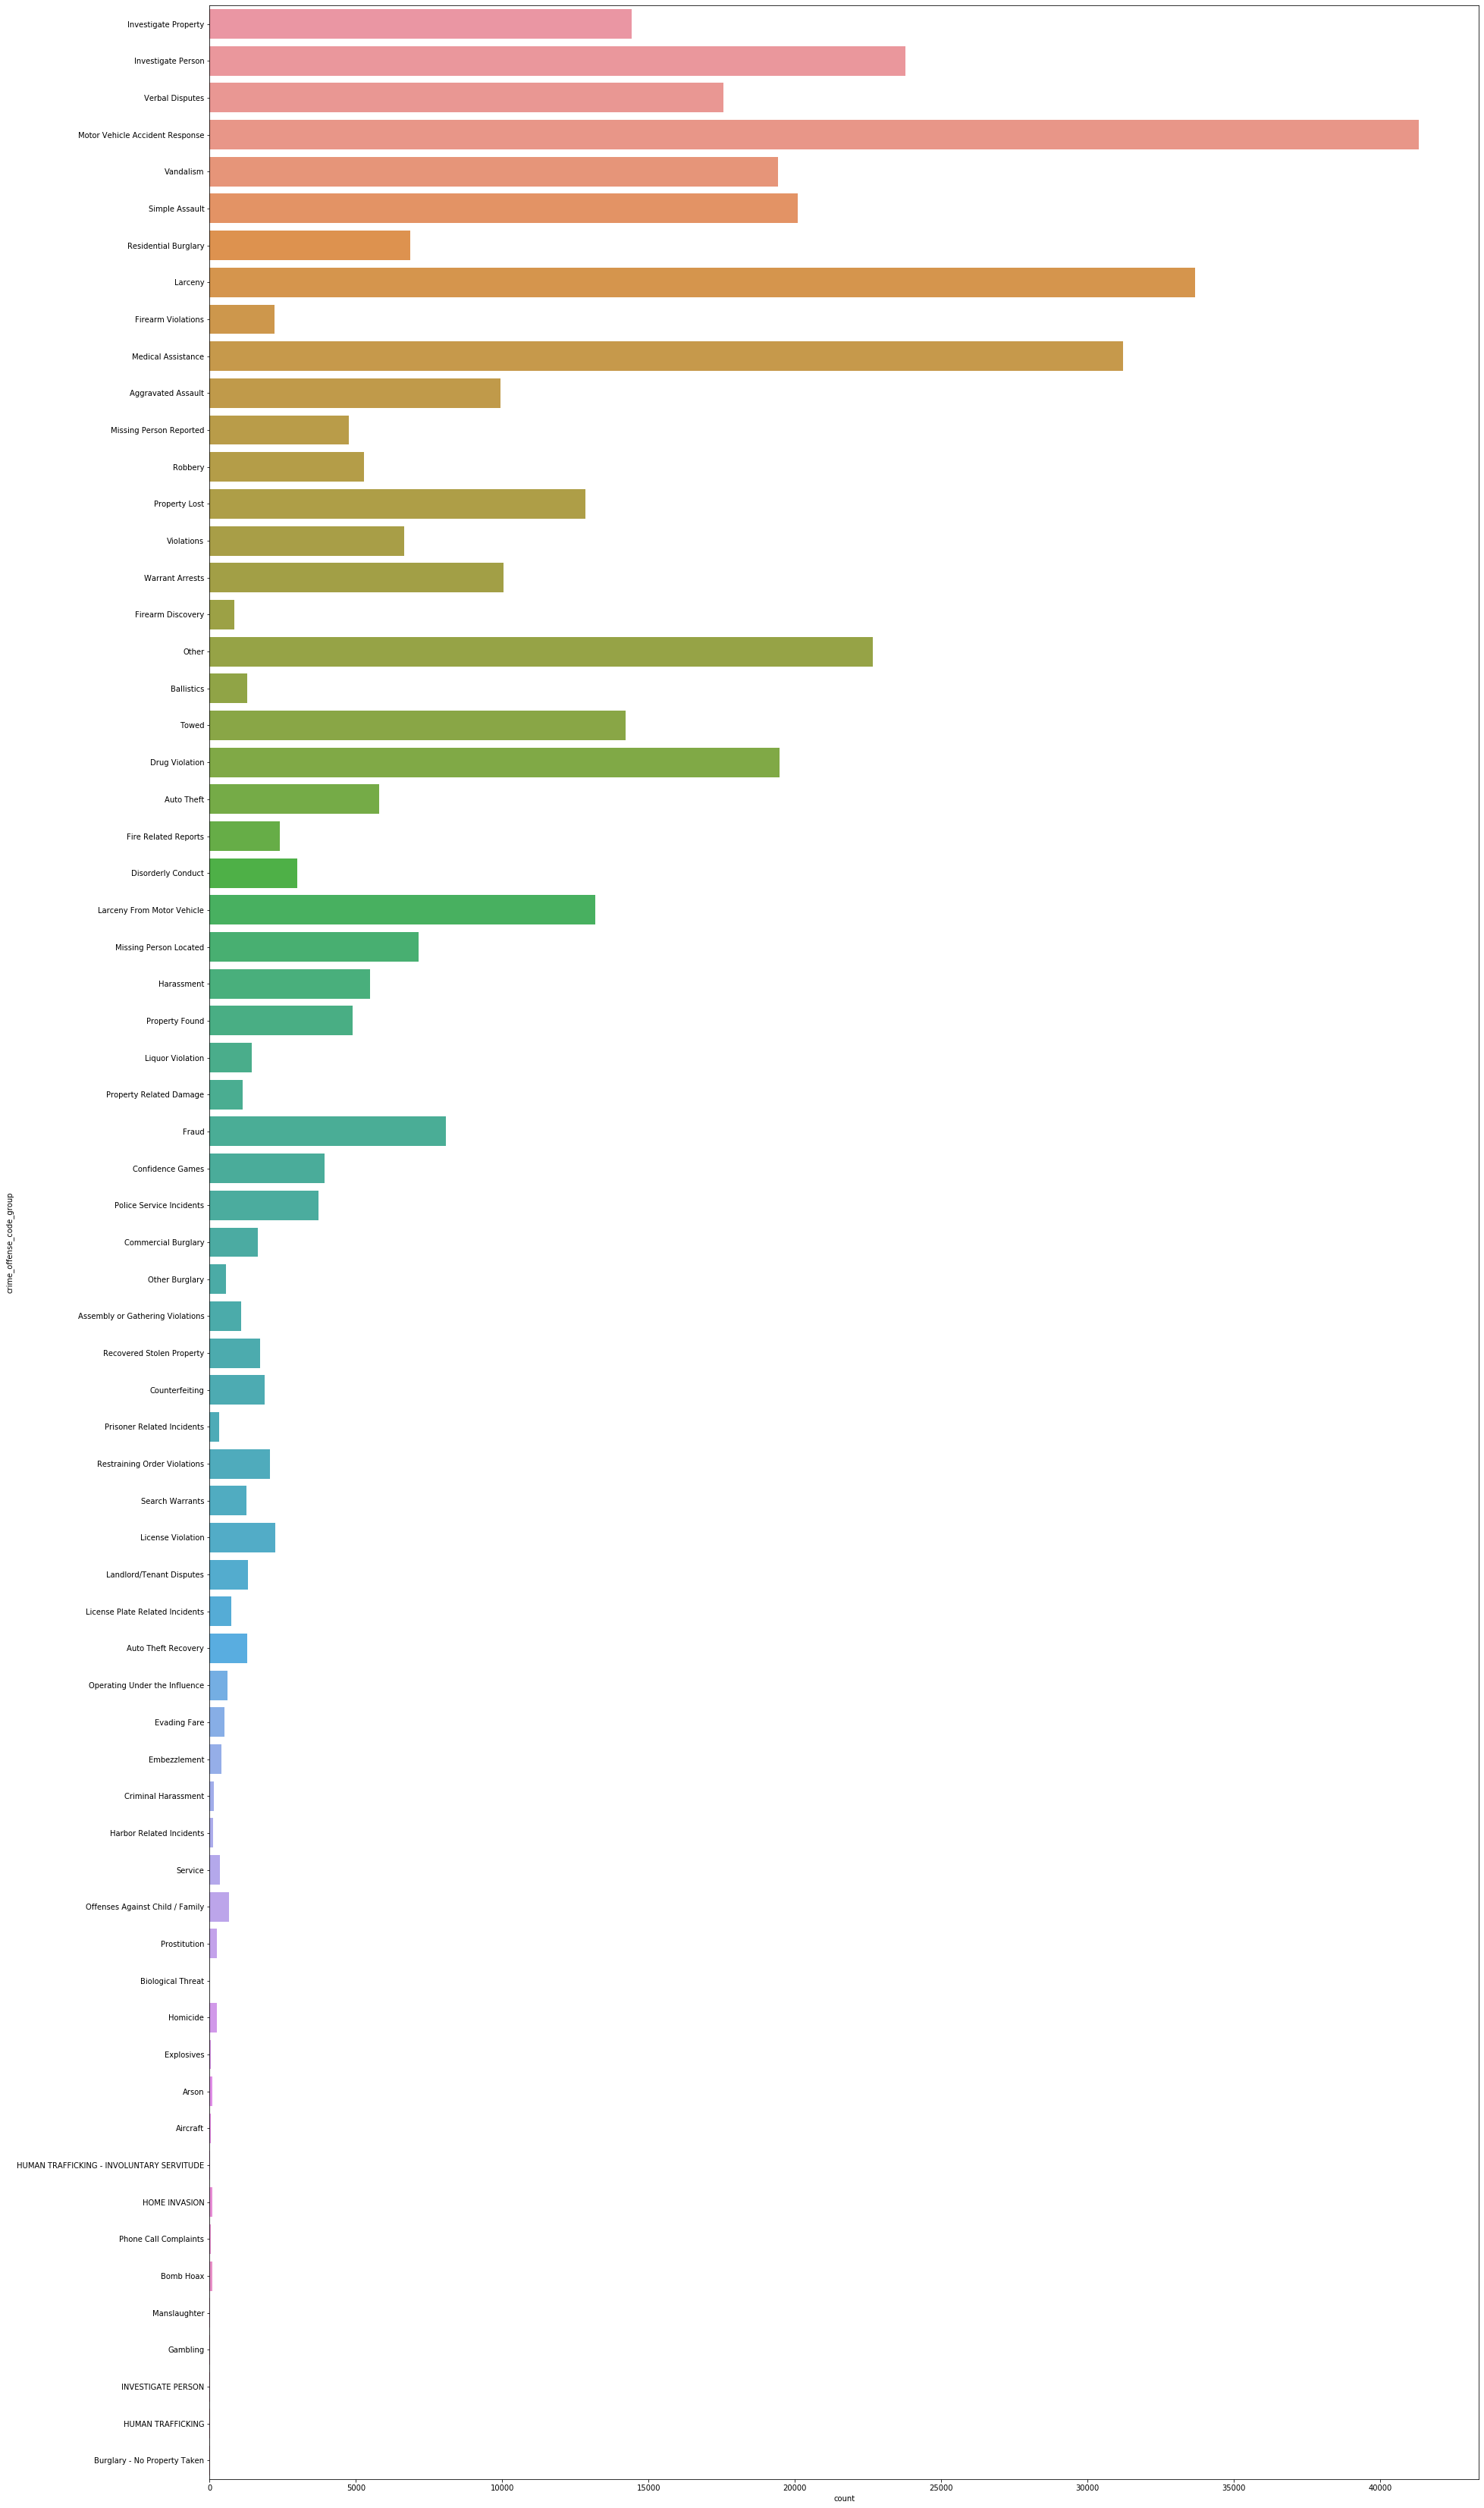

In [10]:
plt.figure(figsize=(30, 60))    #We are giving the size of figure
sns.countplot(y=crime.crime_offense_code_group)  #countplot taking counts of the columns which you choose 
plt.show()

From the plot above we see that the crime code group with the most crime reported is "Motor Vehicle Accident Response". We think it will be benificial to discard instances from this category since they are accidents. There are also quite a few instances categorized as "Medical Assistance" which will be disgarded as well. 

In [11]:
crime = crime[crime.crime_offense_code_group != 'Motor Vehicle Accident Response']
crime = crime[crime.crime_offense_code_group != 'Medical Assistance']

Removing these two categories of crime should improve the accuracy of our prediction model.

To better understand the crime data we will be using and inspire new datasets to add to our model, let's look at how hour of the day, day of the week, and month of the year affect the number of crimes reported.

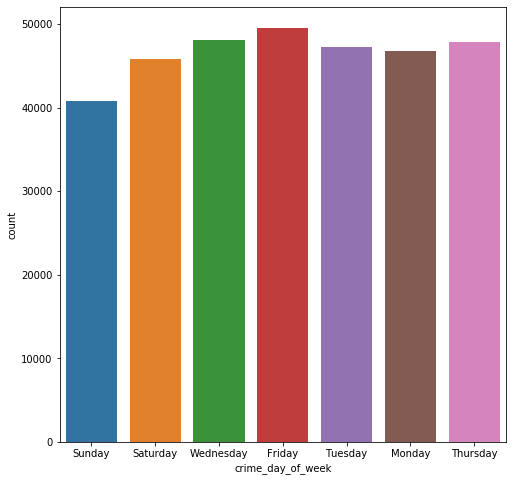

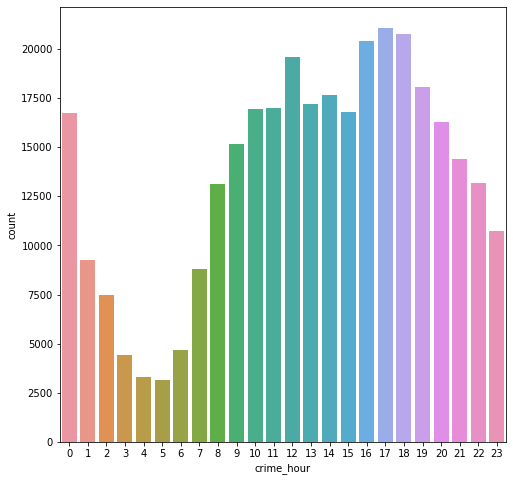

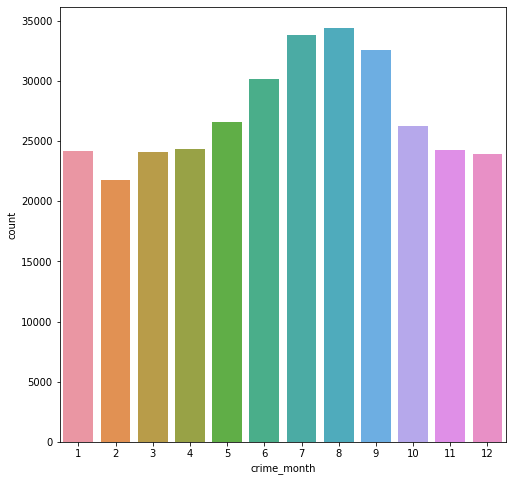

In [12]:
plt.figure(figsize=(8,8))    #We are giving the size of figure
sns.countplot(x=crime.crime_day_of_week)  #countplot taking counts of the columns which you choose 
plt.show() 

plt.figure(figsize=(8,8))    
sns.countplot(x=crime.crime_hour)  
plt.show() 

plt.figure(figsize=(8, 8))    
sns.countplot(x=crime.crime_month)  
plt.show()

# This is too big to graph as-is
#plt.figure(figsize=(8,8))    #We are giving the size of figure
#sns.countplot(x=crime.crime_occurred_on_date)  #countplot taking counts of the columns which you choose 
#plt.show() 

Looking at day of the week, we see that crime is most commonly reported on Fridays and least commonly seen on Sundays. Since Sundays have drastically less crimes reported, there could be a possible correlation between the location religious buildings and crime. Looking into hour of the day, crime appears to be reported most frequently between 4pm and 6pm and is reported the least between 3 am and 6 am. This observation indicates that it might be worth looking into the light density of various areas of the city if the data is available. Looking into the frequency of crimes reported by month, we see that crime is most common from June through September, and is least common in the month of February. There is a noticible increase in crime during Daylight Savings Time (between early March and early November). From these observations, it could be useful to include weather statistics in our model, as there appears to be a correlation between the season and crime frequency.

Now we need to clean up our additional data sets.

In [13]:
bos_weather = []
for df in [humidity, temp, pressure, weather_descript, wind_dir, wind_speed]:
    print(df.name)
    df = df.rename({"boston":df.name}, axis=1)
    bos_weather.append(df)

humidity
temperature
pressure
weather_description
wind_direction
wind_speed


In [14]:
### NOTE ###
# The following three cells were only to handle the original weather files, which contained many cities
# Code kept for posterity

In [15]:
# The files have many cities in them
#for df in bos_weather:
#    df.drop(list(df.filter(regex="^((?!Boston|datetime).)*$")), axis = 1, inplace=True)

In [16]:
# The scraper didn't specify the temp units, which inexplicably default to Kelvin
#def temp_k_to_f(kelvin):
#    return ((kelvin - 273.15) * 9/5 + 32)
#temp['Boston'] = temp['Boston'].apply(temp_k_to_f)

In [17]:
# And, to save upload space, let's write out our new files
#for df in bos_weather:
#    df.to_csv('./data/weather/' + df.name + '.csv')

In [18]:
# Same as a SQL inner join
weather = reduce(lambda left,right: pd.merge(left,right,on=["datetime"], how="inner"), bos_weather)
weather.drop(weather.filter(regex="unnamed"), axis=1, inplace=True)

# First row is NaN due to the join, drop it
weather.drop(weather.index[0], inplace=True)

In [19]:
# There are still some NaNs, so let's fill them with the closest neighbor
weather.isna().any()

datetime               False
humidity                True
temperature             True
pressure                True
weather_description    False
wind_direction         False
wind_speed             False
dtype: bool

In [20]:
weather.fillna(method="ffill", inplace=True)
weather.isna().any()

datetime               False
humidity               False
temperature            False
pressure               False
weather_description    False
wind_direction         False
wind_speed             False
dtype: bool

In [21]:
### police ###

# None of the nulls here matter
police.isnull().any()

police_x               False
police_y               False
police_objectid        False
police_bldg_id         False
police_bid             False
police_address         False
police_point_x         False
police_point_y         False
police_name            False
police_neighborhood    False
police_city            False
police_zip             False
police_ft_sqft          True
police_story_ht         True
police_parcel_id       False
dtype: bool

In [22]:
### fire ###

# Lots of nulls here, but only ones that actually matter are fire_x and fire_y 
# (fire_xcoord and fire_ycoord are the same, but unsigned)
fire.isnull().any()

fire_x             False
fire_y             False
fire_objectid_1    False
fire_objectid       True
fire_bfd_id         True
fire_map_id         True
fire_mapcode        True
fire_loccode        True
fire_locdept        True
fire_locname        True
fire_loccontact     True
fire_locphone       True
fire_locstno        True
fire_locaddr       False
fire_locowner       True
fire_locward        True
fire_locparcl       True
fire_locprect       True
fire_locplan        True
fire_study          True
fire_above          True
fire_above_desc     True
fire_source         True
fire_geoaddress    False
fire_pd            False
fire_ct90           True
fire_xcoord         True
fire_ycoord         True
dtype: bool

In [23]:
### community ###

# None of the nulls here matter
community.isnull().any()

community_x           False
community_y           False
community_fid         False
community_objectid     True
community_site        False
community_phone       False
community_fax          True
community_street      False
community_neigh       False
community_zip         False
dtype: bool

In [24]:
### parks ###

# None of the nulls here matter
parks.isnull().any()

parks_objectid            False
parks_site_name           False
parks_ownership           False
parks_protection           True
parks_typecode            False
parks_district            False
parks_acres               False
parks_address             False
parks_zonagg              False
parks_typelong            False
parks_os_own_jur           True
parks_os_mngmnt            True
parks_pos                 False
parks_pa                  False
parks_alt_name             True
parks_agncyjuris           True
parks_shape_starea__      False
parks_shape_stlength__    False
parks_shapestarea         False
parks_shapestlength       False
parks_park_id              True
parks_region              False
dtype: bool

In [25]:
### weather ###

# No nulls, hooray
weather.isnull().any()

datetime               False
humidity               False
temperature            False
pressure               False
weather_description    False
wind_direction         False
wind_speed             False
dtype: bool

In [26]:
# Need to clean up datetime a bit for the next merge

# Ensure they're in datetime64 format
crime["datetime"] = pd.to_datetime(crime["datetime"].str.replace(".", ":"))
weather["datetime"] = pd.to_datetime(weather["datetime"].str.replace(".", ":"))

# Sort by date
crime.sort_values(by="datetime", inplace=True)
weather.sort_values(by="datetime", inplace=True)

In [27]:
# Since the crime data is from 2015-2019, and weather from 2012-2017, we'd be throwing out
# a lot of data if we only joined on those. As such, we'll examine weather separately
# from the other data, which is assumed (big if) to be static

# Also to consider is the fact that some of the crime reports almost certainly had the
# hour either missing or filled in as 0 by default, so the weather may not always correlate

crime_with_weather = pd.merge_asof(
                                    crime, weather, 
                                    on="datetime", 
                                    direction="nearest",
                                    tolerance=pd.Timedelta("1 hour")
                                  )

In [28]:
# Drop the rows for which we don't have weather
crime_with_weather.dropna(subset=["humidity",
                                  "temperature",
                                  "pressure",
                                  "weather_description",
                                  "wind_direction",
                                  "wind_speed"], 
                          inplace=True)

In [29]:
crime_with_weather.head()

crime_incident_number  crime_offense_code crime_offense_code_group  \
0            I162013546                3201            Property Lost   
1            I172040657                2629               Harassment   
2            I152059178                2647                    Other   
3            I152067251                1102                    Fraud   
4            I152051083                3130          Search Warrants   

         crime_offense_description crime_district crime_reporting_area  \
0                  PROPERTY - LOST             B3                  433   
1                       HARASSMENT            C11                  397   
2        THREATS TO DO BODILY HARM            C11                  359   
3  FRAUD - FALSE PRETENSE / SCHEME             A1                   93   
4                   SEARCH WARRANT             A7                   20   

  crime_shooting   datetime  crime_year  crime_month crime_day_of_week  \
0            NaN 2015-06-15        2015            6            Monday   
1            NaN 2015-06-15        2015            6            Monday   
2            NaN 2015-06-15        2015            6            Monday   
3            NaN 2015-06-15        2015            6            Monday   
4            NaN 2015-06-15        2015            6            Monday   

   crime_hour crime_ucr_part     crime_street  crime_lat  crime_long  \
0           0     Part Three       NORFOLK ST  42.283634  -71.082813   
1           0       Part Two     MELBOURNE ST  42.291093  -71.065945   
2           0       Part Two    WASHINGTON ST  42.293606  -71.071887   
3           0       Part Two  FANEUIL HALL SQ  42.360205  -71.056208   
4           0     Part Three         PARIS ST  42.377023  -71.032247   

                crime_location  humidity  temperature  pressure  \
0  (42.28363434, -71.08281320)      70.0    60.952634    1031.0   
1  (42.29109287, -71.06594539)      70.0    60.952634    1031.0   
2  (42.29360585, -71.07188650)      70.0    60.952634    1031.0   
3  (42.36020464, -71.05620816)      70.0    60.952634    1031.0   
4  (42.37702319, -71.03224730)      70.0    60.952634    1031.0   

  weather_description  wind_direction  wind_speed  
0    scattered clouds           137.0         3.0  
1    scattered clouds           137.0         3.0  
2    scattered clouds           137.0         3.0  
3    scattered clouds           137.0         3.0  
4    scattered clouds           137.0         3.0

With weather in the crime data frame we can plot how the frequency of crime depends on temperature. For this we will round temperature to the nearest whole number.

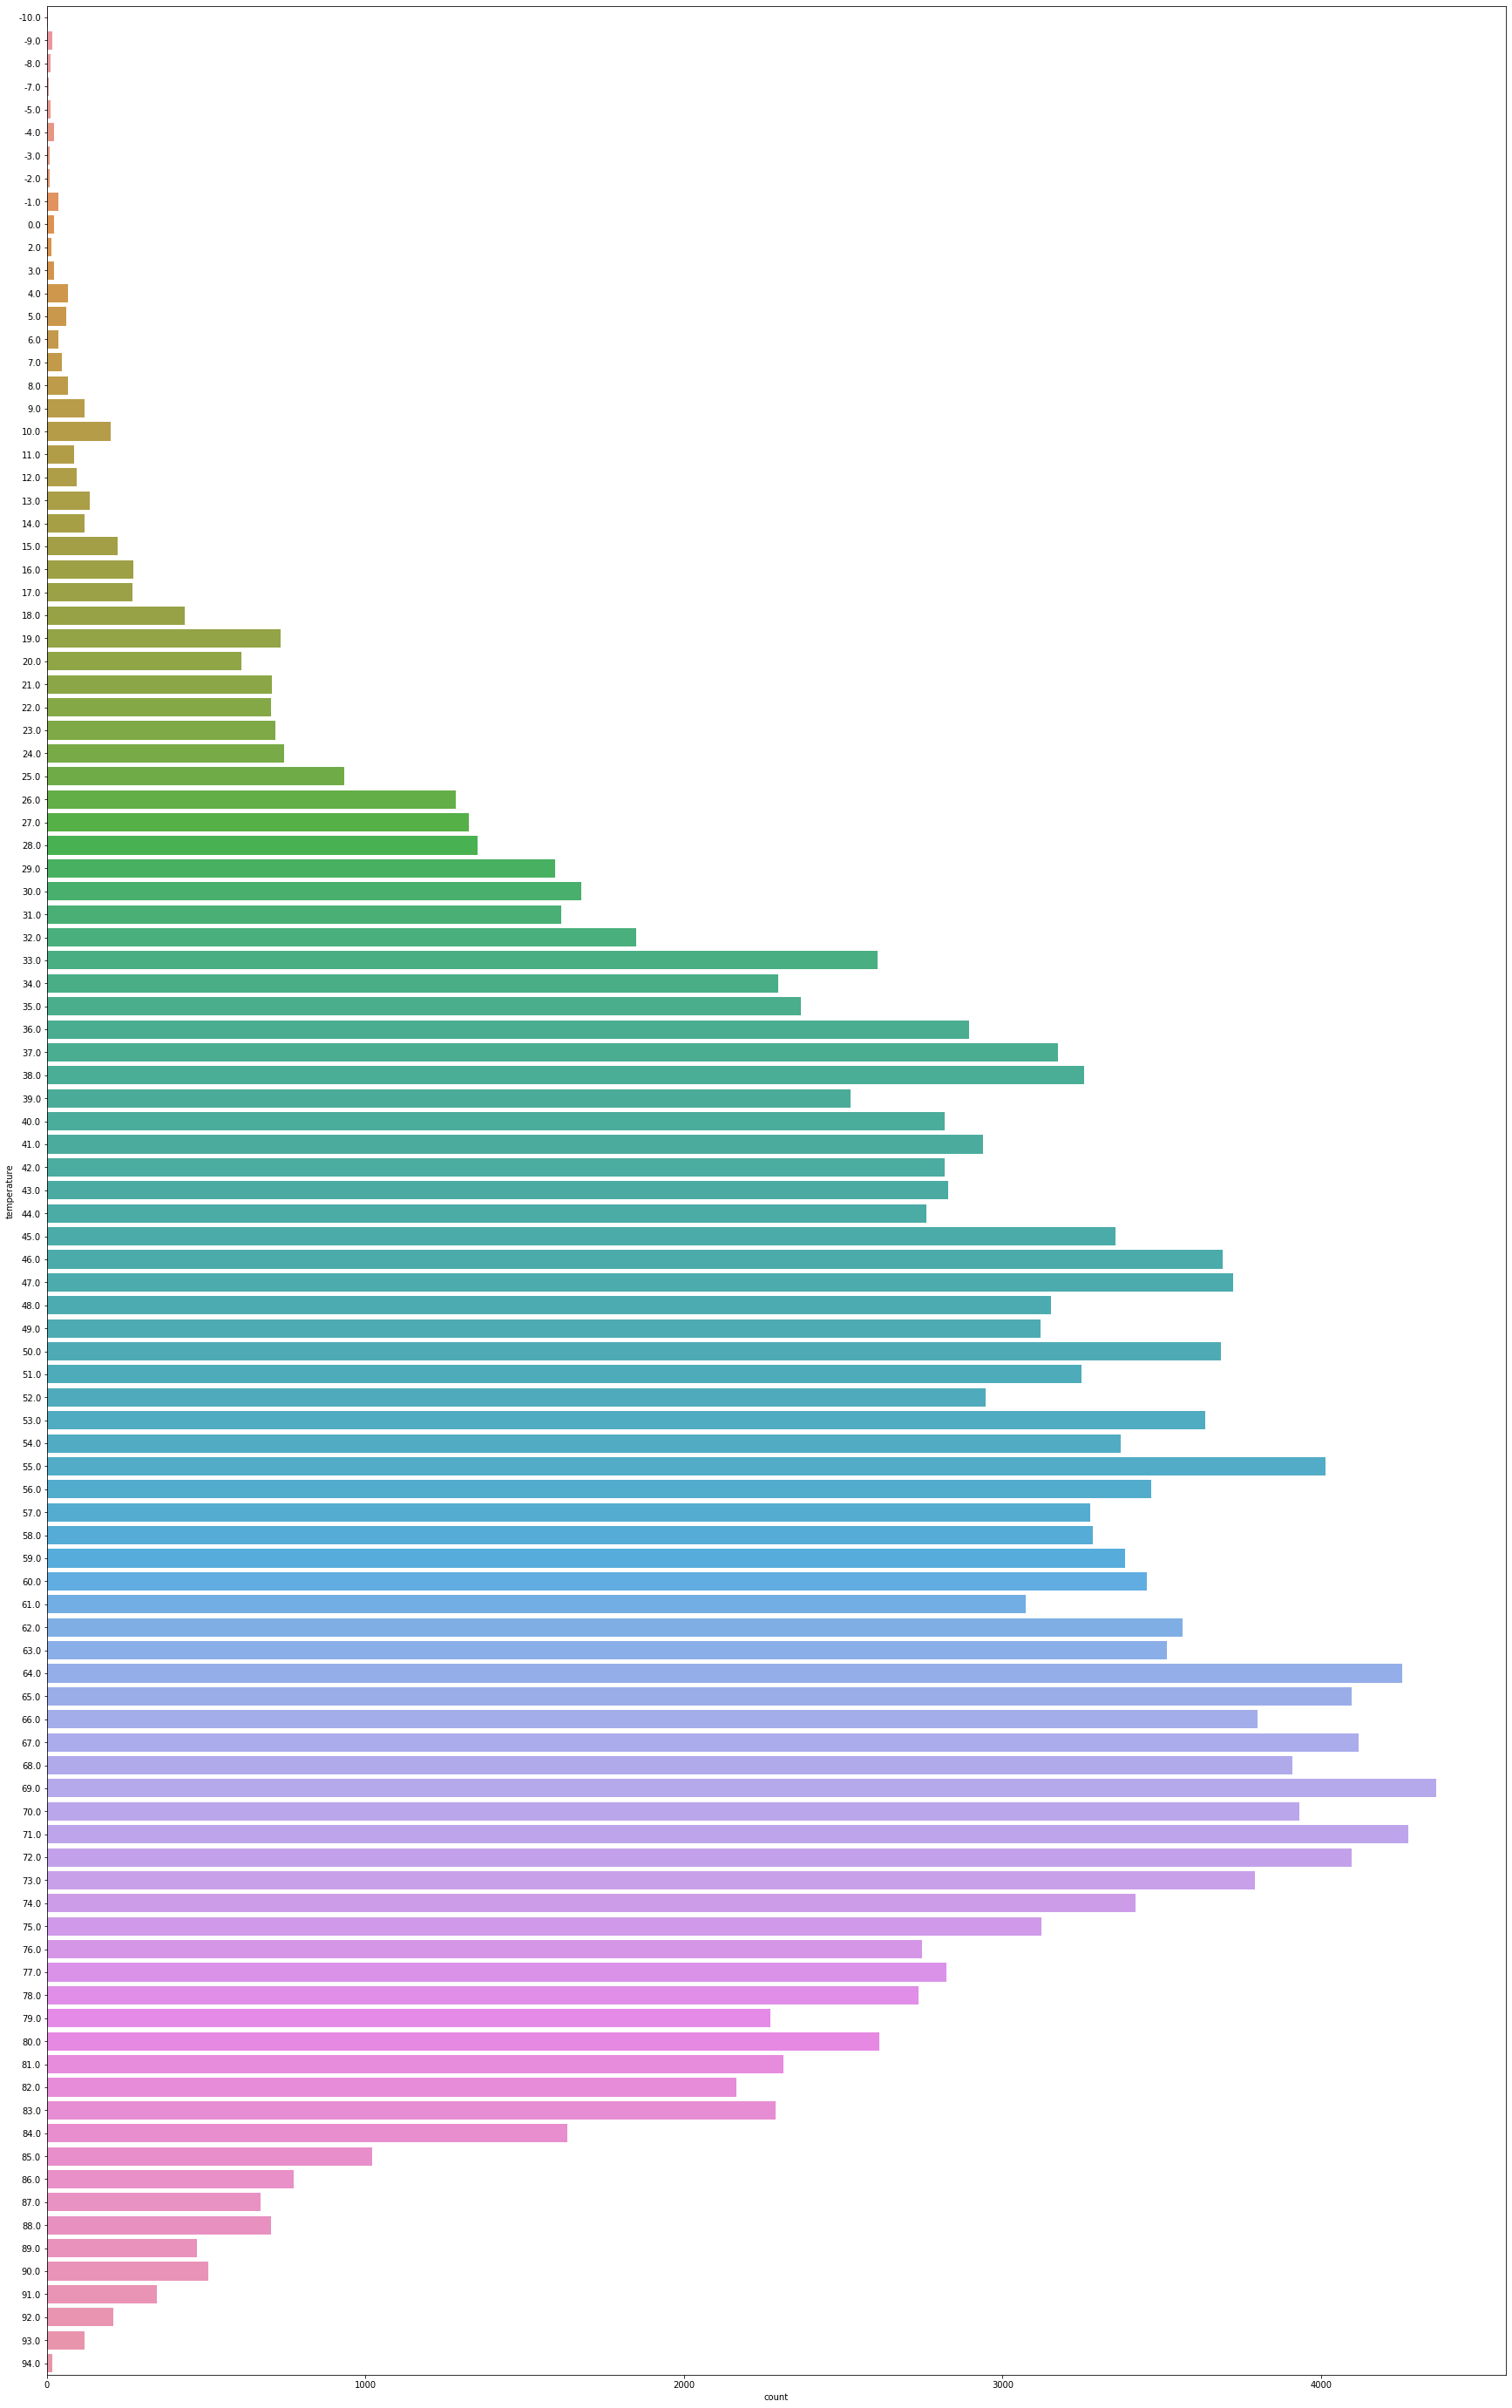

In [30]:
plt.figure(figsize=(30, 50))    #We are giving the size of figure
sns.countplot(y=crime_with_weather.temperature.round(decimals=0))  #countplot taking counts of the columns which you choose 
plt.show() 

We see a significant increase in crime when temperatures are above freezing and below 85 degrees fahrenheit. We can also plot crime instances against the weather description.

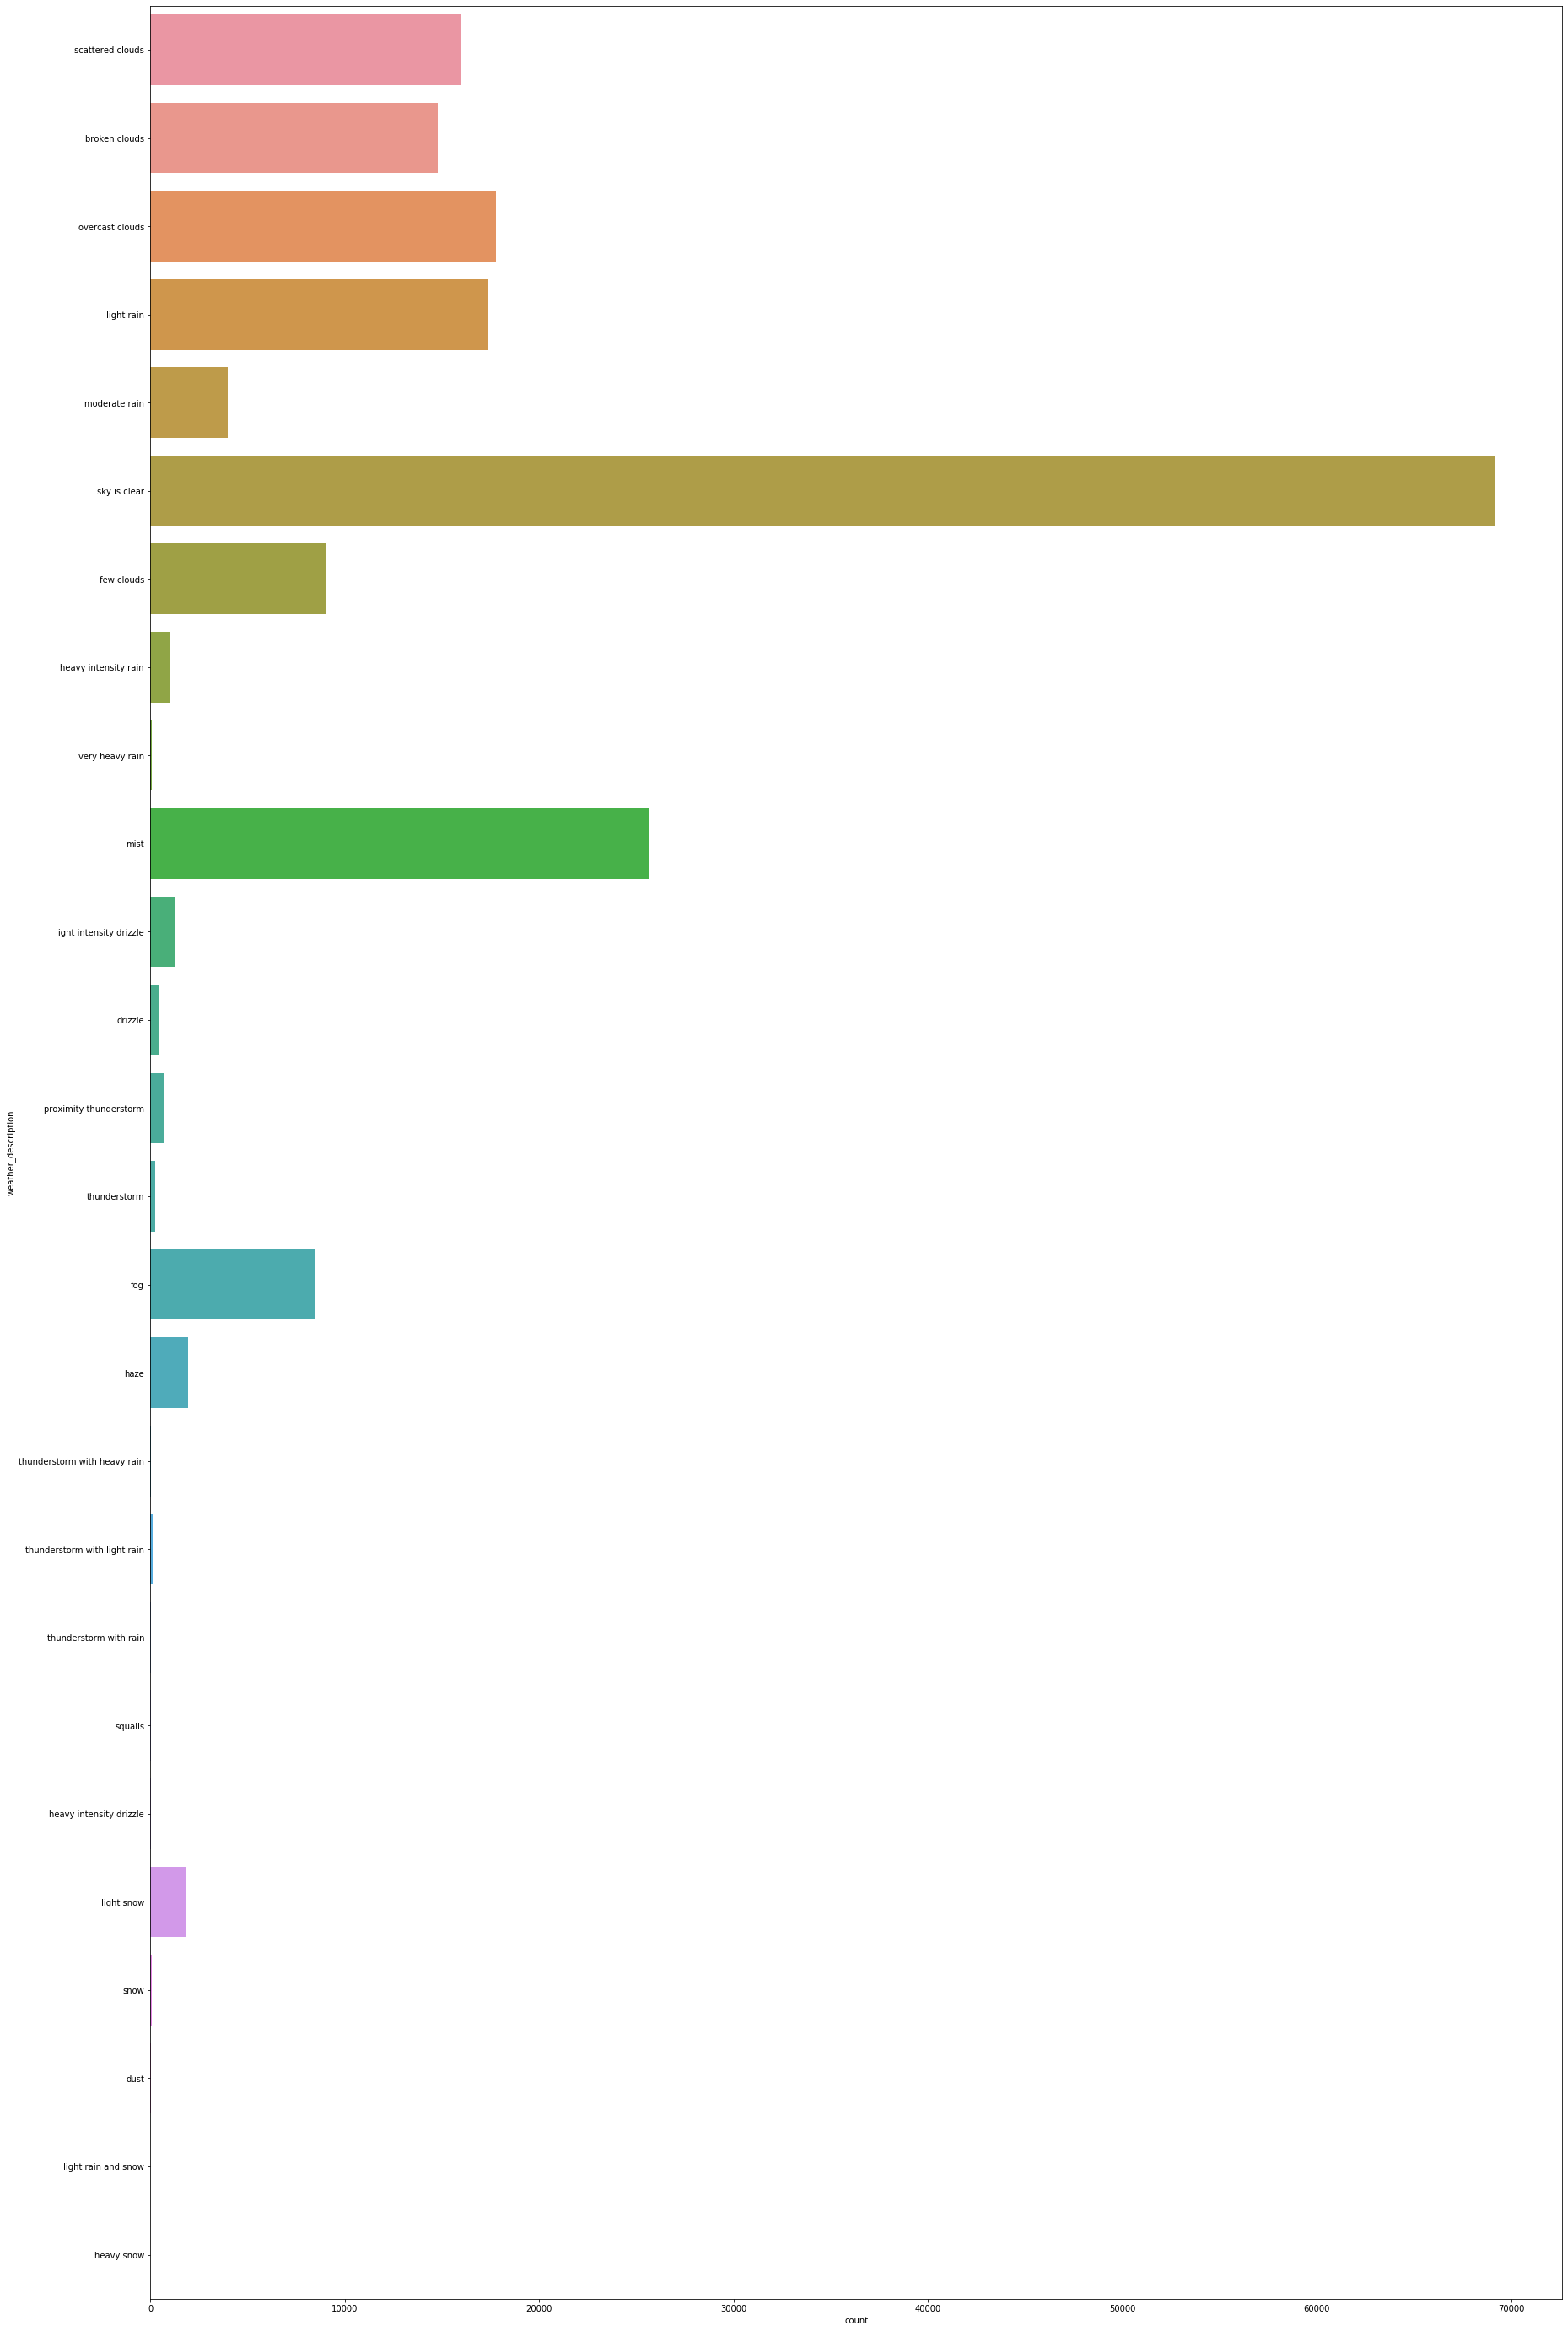

In [31]:
plt.figure(figsize=(30, 50))    #We are giving the size of figure
sns.countplot(y=crime_with_weather.weather_description)  #countplot taking counts of the columns which you choose 
plt.show()

When plotting against the weather description we see that an overwhelming amount of crime happens when there are clear skies. 

In [32]:
coords = []
for x, y in zip(crime.crime_long.tail(1000), crime.crime_lat.tail(1000)):
    coords.append((x,y))

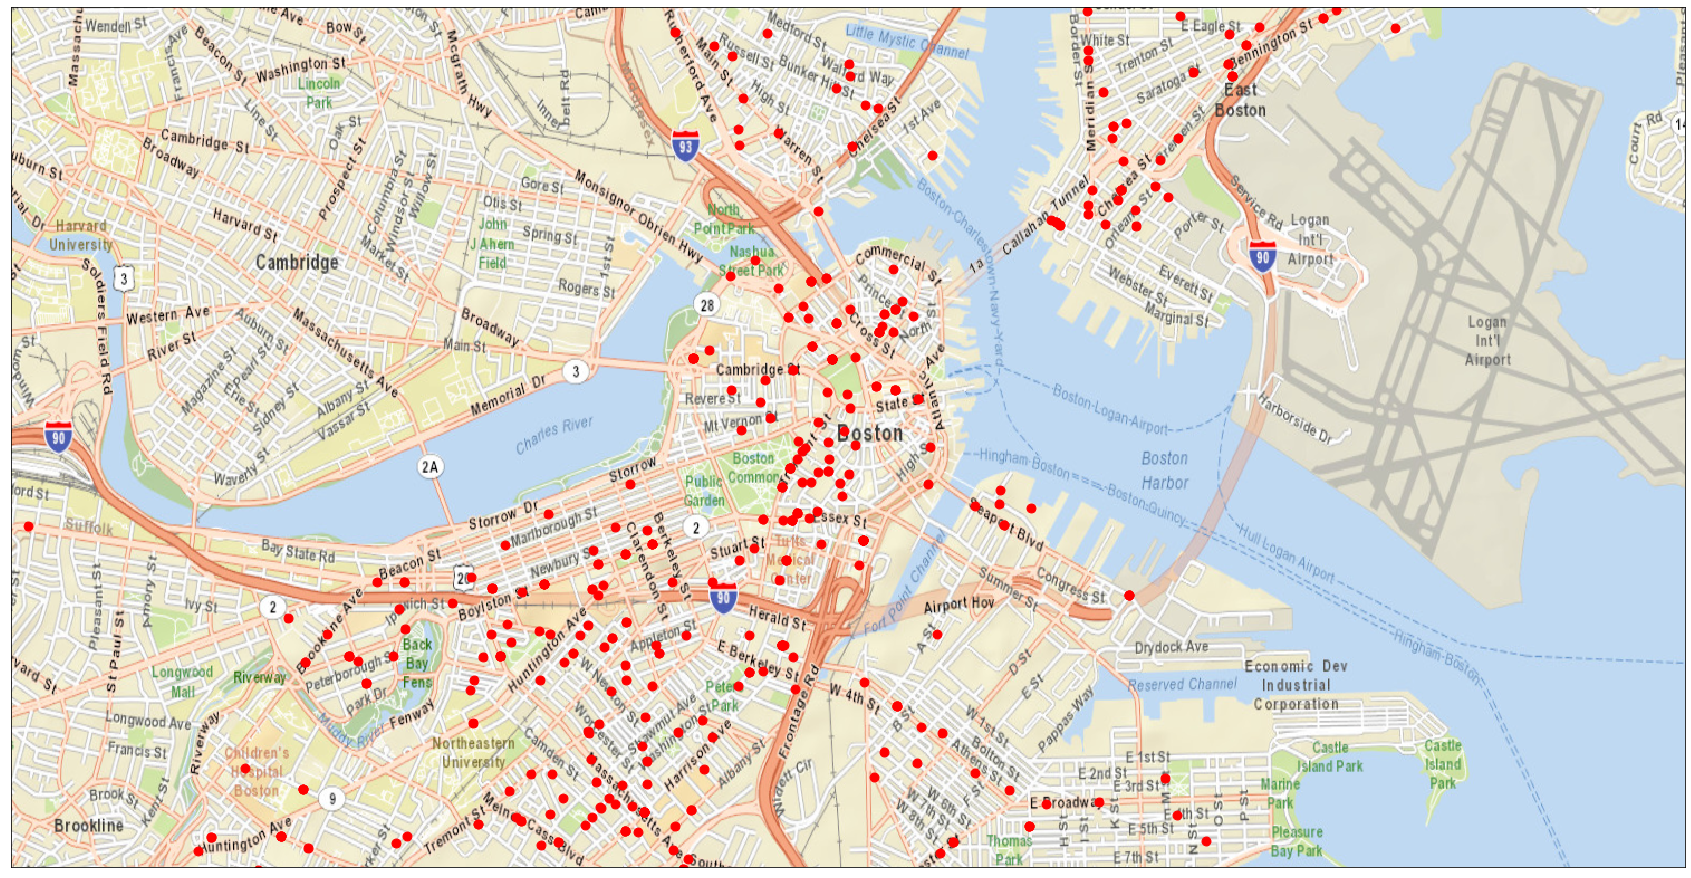

In [33]:
"""
Generates a map of Boston and plots crime locations as taken from previous cell.

Basemap:
* epsg is European Petroleum Survey Group; a common way of identifying map datums - for example,
  epsg wgs84 is a global datum which Google Maps uses. Using it for this would add additional difficulty,
  as such, 2805 (a Boston mainland specific datum) is used.
* projection being used is Mercator, which is unfortunately the best cylindrical conformal map available to Basemap.
* lon_0/lat_0 are the center of the map.
* llcrnrlon/lat is lon/lat of the lower-left map boundary.
* urcrnrlon/lat is the lon/lat of the upper-right map boundary.

arcgisimage:
* service: actually provides the map image.
* xpixels: sets horizontal resolution; vertical is inferred.
* verbose: if true, returns URL as well.

scatter:
* x: longitude from coords
* y: latitude from coords
* marker: marker style
* color: color
* s: size in pixels
"""

plt.figure(figsize=(30,30))
map = Basemap(
                epsg=2805,
                resolution='i',
                projection='merc',
                lon_0=-71.057083,
                lat_0=42.361145,
                llcrnrlon=-71.125305,
                llcrnrlat=42.332037,
                urcrnrlon=-70.991678,
                urcrnrlat=42.382334
            )
map.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels=1500, verbose=False)
for x, y in coords:
    map.scatter(x, y, latlon=True, marker='o', color='r', s=80)
plt.show()

In [34]:
# https://github.com/drazenz/heatmap/blob/master/heatmap.py

def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )


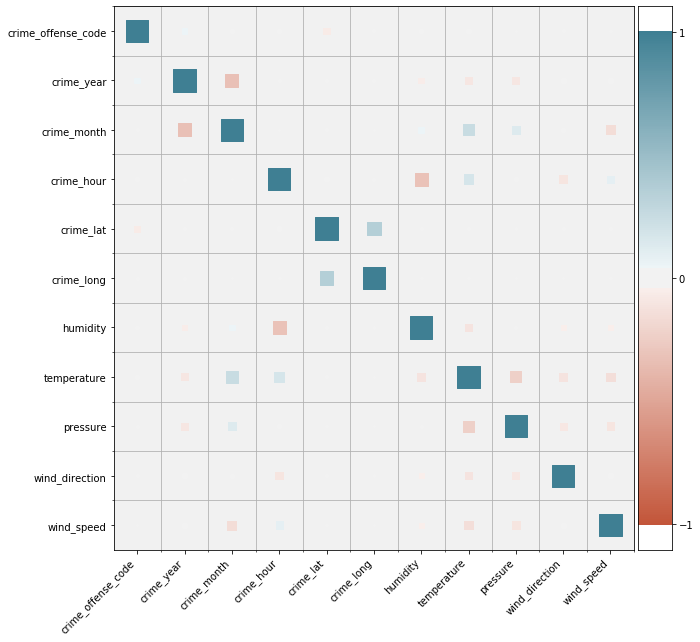

In [35]:
police_copy = police
crime_copy = crime
police_copy.columns = police_copy.columns.str.replace("police_x", "long")
police_copy.columns = police_copy.columns.str.replace("police_y", "lat")
police_copy.sort_values("long", inplace=True)
crime_copy.sort_values("crime_long", inplace=True)
police_sta_crime = pd.merge_asof(
                                    police_copy, crime, 
                                    left_on="long",
                                    right_on="crime_long",
                                    direction="nearest",
                                  )
plt.figure(figsize=(10, 10))
corrplot(crime_with_weather.corr())

In [36]:
pd.set_option('display.max_rows', df.shape[0]+1)
crime[["crime_offense_code", "crime_offense_description"]].groupby("crime_offense_code").sum()

crime_offense_description
crime_offense_code                                                   
111                 MURDER, NON-NEGLIGIENT MANSLAUGHTERMURDER, NON...
112                                        KILLING OF FELON BY POLICE
121                 MANSLAUGHTER - VEHICLE - NEGLIGENCEMANSLAUGHTE...
123                 MANSLAUGHTER - NON-VEHICLE - NEGLIGENCEMANSLAU...
301                 ROBBERY - STREETROBBERY - STREETROBBERY - STRE...
311                 ROBBERY - COMMERCIALROBBERY - COMMERCIALROBBER...
315                                          ROBBERY - KNIFE - STREET
335                 ROBBERY - UNARMED - CHAIN STOREROBBERY - UNARM...
339                 ROBBERY - UNARMED - STREETROBBERY - UNARMED - ...
349                 ROBBERY ATTEMPT - KNIFE - BANKROBBERY ATTEMPT ...
351                 ROBBERY - BANKROBBERY - BANKROBBERY - BANKROBB...
361                 ROBBERY - OTHERROBBERY - OTHERROBBERY - OTHERR...
371                 ROBBERY - HOME INVASIONROBBERY - HOME INVASION...
381                 ROBBERY - CAR JACKINGROBBERY - CAR JACKINGROBB...
402                 ASSAULT & BATTERY D/W - KNIFEASSAULT & BATTERY...
403                 ASSAULT & BATTERY D/W - OTHERASSAULT & BATTERY...
404                      A&B HANDS, FEET, ETC.  - MED. ATTENTION REQ.
413                 ASSAULT - AGGRAVATED - BATTERYASSAULT - AGGRAV...
423                 ASSAULT - AGGRAVATEDASSAULT - AGGRAVATEDASSAUL...
432                             ASSAULT D/W - KNIFE ON POLICE OFFICER
511                 B&E RESIDENCE NIGHT - ATTEMPT FORCEB&E RESIDEN...
520                 BURGLARY - RESIDENTIAL - FORCEBURGLARY - RESID...
521                 BURGLARY - RESIDENTIAL - ATTEMPTBURGLARY - RES...
522                 BURGLARY - RESIDENTIAL - NO FORCEBURGLARY - RE...
527                 B&E RESIDENCE DAY - NO PROP TAKENB&E RESIDENCE...
530                                   B&E NON-RESIDENCE NIGHT - FORCE
540                 BURGLARY - COMMERICAL - FORCEBURGLARY - COMMER...
541                 BURGLARY - COMMERICAL - ATTEMPTBURGLARY - COMM...
542                 BURGLARY - COMMERICAL - NO FORCEBURGLARY - COM...
547                 B&E NON-RESIDENCE DAY - NO PROP TAKENB&E NON-R...
560                 BURGLARY - OTHER - FORCEBURGLARY - OTHER - FOR...
561                 BURGLARY - OTHER - ATTEMPTBURGLARY - OTHER - A...
562                 BURGLARY - OTHER - NO FORCEBURGLARY - OTHER - ...
611                 LARCENY PICK-POCKETLARCENY PICK-POCKETLARCENY ...
612                 LARCENY PURSE SNATCH - NO FORCE LARCENY PURSE ...
613                 LARCENY SHOPLIFTINGLARCENY SHOPLIFTINGLARCENY ...
614                 LARCENY THEFT FROM MV - NON-ACCESSORYLARCENY T...
615                 LARCENY THEFT OF MV PARTS & ACCESSORIESLARCENY...
616                 LARCENY THEFT OF BICYCLELARCENY THEFT OF BICYC...
617                 LARCENY THEFT FROM BUILDINGLARCENY THEFT FROM ...
618                 LARCENY THEFT FROM COIN-OP MACHINELARCENY THEF...
619                 LARCENY ALL OTHERSLARCENY ALL OTHERSLARCENY AL...
623                 LARCENY SHOPLIFTING $50 TO $199LARCENY SHOPLIF...
624                 LARCENY NON-ACCESSORY FROM VEH. $50 TO $199LAR...
627                 LARCENY IN A BUILDING $50 TO $199LARCENY IN A ...
629                 LARCENY OTHER $50 TO $199LARCENY OTHER $50 TO ...
633                 LARCENY SHOPLIFTING UNDER $50LARCENY SHOPLIFTI...
637                 LARCENY IN A BUILDING UNDER $50LARCENY IN A BU...
639                 LARCENY OTHER UNDER $50LARCENY OTHER UNDER $50...
670                 RECOVERED STOLEN PLATERECOVERED STOLEN PLATERE...
706                 AUTO THEFT - MOTORCYCLE / SCOOTERAUTO THEFT - ...
714                                                  AUTO THEFT OTHER
724                 AUTO THEFTAUTO THEFTAUTO THEFTAUTO THEFTAUTO T...
727                 AUTO THEFT - LEASED/RENTED VEHICLEAUTO THEFT -...
735                 RECOVERED - MV RECOVERED IN BOSTON (STOLEN OUT...
770                 AUTO THEFT - RECOVERED IN BY POLIC